<a href= "https://hrs.isr.umich.edu/sites/default/files/meta/2002/core/codebook/h02_00.html?_ga=2.14020593.714056361.1676427746-1610833755.1676427746">codebook</a>

In [5]:
# Importing the libraries
import glob

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#### Background:

The current academic literature in predicting mortality has extensively focused on disease and frailty, although social, behavioral, and psychological statuses may herald broad physiological decline. I tested the effectiveness of the machine learning algorithms on the NSHAP sample in Project 1 and learnt the important features predicting mortality. This project will extend the analysis by 1) using a different set of predictors 2) applying some new algorithms in addition to tree-based algorithm 3) using a different dataset.

#### Context:

Household Retire Survey (HRS) is a nationally representative survey of the older US adults (aged 50-61) collected every two years from 1992 to 2018. I use 2002 characteristics as baseline and 2016 disposition status (reported in the 2018 wave) as target. 

#### Goal
The goal of this project is to predict mortality in the next 14 years using the baseline characteristics in 2002. I will also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. The findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process.

#### The task: 
The task is to train a binary classification model to predict mortality in the next 14 years using the baseline characteristics in 2002.

In [181]:
# Importing all disposition files of every wave
all_dispositon_files = glob.glob('hrs_data/disposition/*.csv')
# Create an empty dataframe to store all the dataframes
dispositon_data_full = pd.DataFrame()
# Loop through all the files and read them into a list of dataframes
for filename in all_dispositon_files:
    df_disposition = pd.read_csv(filename, index_col=None, header=0)
    dispositon_data_full = pd.concat([dispositon_data_full, df_disposition], axis=0, ignore_index=True)
# Concatenate all the dataframes into one dataframe
dispositon_data = dispositon_data_full.iloc[:, :2].copy()
# As these are all the disposition files, we can set deceased to 1
dispositon_data['deceased'] = 1
dispositon_data

,HHID,PN,deceased
0,10475,10,1
1,10592,10,1
2,11219,10,1
3,11575,20,1
4,11626,10,1
...,...,...,...
10027,213379,10,1
10028,213410,10,1
10029,213418,10,1
10030,213428,10,1


In [190]:
# Again, import all the core files in the baseline wave 2002
all_core_files = glob.glob('hrs_data/*.csv')
# Create an empty dataframe to concatenate with all the dataframes
core_data_raw = pd.DataFrame()
# Loop through all the files and read them into a dataframe
for filename in all_core_files:
    dfcore = pd.read_csv(filename, index_col=None, header=0)
    col_to_merge = dfcore.columns.difference(core_data_raw.columns)
    if filename.endswith('R.csv'):
        core_data_raw = pd.concat([core_data_raw, dfcore[col_to_merge]], axis=1)
    elif filename.endswith('H.csv'):
        dfmerge = pd.concat([dfcore[col_to_merge], dfcore['HHID']], axis=1)
        core_data_raw = core_data_raw.merge(dfmerge,
                                            on=["HHID"], how="inner")
# Select the columns we need
core_data = core_data_raw[['HHID', 'PN',
                           'HC139', 'HC005', 'HC010', 'HC001', 'HC070',
                           'HC117', 'HC128', 'HX067_R', 'HB014A', 'HC134', 'HQ331', 'HQ376', 'HMARITAL', 'HX060_R',
                           'HB031A',
                           'HB053', 'HE012', 'HE046', 'HF174', 'HG092', 'HF176',
                           'HG001'
                           ]]
# Show the first 5 rows of the dataframe
core_data.head()

,HHID,PN,HC139,HC005,HC010,HC001,HC070,HC117,HC128,HX067_R,...,HMARITAL,HX060_R,HB031A,HB053,HE012,HE046,HF174,HG092,HF176,HG001
0,3,10,170.0,5.0,5.0,3.0,5.0,5.0,1.0,1936.0,...,1.0,1.0,1.0,1,5.0,12.0,5.0,20.0,1.0,5.0
1,3,20,179.0,5.0,5.0,3.0,1.0,5.0,5.0,1938.0,...,1.0,2.0,1.0,1,5.0,12.0,5.0,100.0,1.0,5.0
2,10001,10,180.0,5.0,5.0,2.0,5.0,5.0,5.0,1939.0,...,6.0,1.0,1.0,3,NaN,NaN,5.0,9998.0,3.0,5.0
3,10003,30,120.0,1.0,5.0,1.0,5.0,5.0,5.0,1956.0,...,5.0,2.0,1.0,1,NaN,NaN,5.0,0.0,0.0,5.0
4,10004,10,230.0,1.0,5.0,2.0,1.0,5.0,1.0,1939.0,...,1.0,1.0,1.0,1,1.0,95.0,1.0,200.0,1.0,5.0


In [183]:
# Merge the core data with the disposition data
df02_d = core_data.merge(dispositon_data, on=["HHID", "PN"], how="left")
# Fill the respondents not appearing in the disposition data as not deceased
df02_d['deceased'] = df02_d['deceased'].fillna(0)
# Show the breakdown of deceased and not deceased
df02_d['deceased'].value_counts()

0.0    10973
1.0     9245
Name: deceased, dtype: int64

In [184]:
# Preprocessing the continuous/ordinal variables
con_col = ['HC139', 'HC001', 'HB014A', 'HB053', 'HE046', 'HG092', 'HF176',
           'HX067_R', 'HC134', 'HQ331', 'HQ376']
# Create a new dataframe with only continuous/ordinal variables
df02_d_ord = df02_d[con_col].copy()
# Construct the household asset variable
wealth_col = ['HC134', 'HQ331', 'HQ376']
for col in wealth_col:
    # Set values of no wealth to 0
    df02_d_ord[col] = df02_d_ord[col].replace(np.nan, 0)
df02_d_ord['wealth_amt'] = df02_d_ord['HC134'] + df02_d_ord['HQ331'] + df02_d_ord['HQ376']
# Scale the wealth variable to 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
df02_d_ord['wealth_amt'] = scaler.fit_transform(df02_d_ord['wealth_amt'].values.reshape(-1, 1))
df02_d_ord.drop(['HC134', 'HQ331', 'HQ376'], axis=1, inplace=True)
# Construct the age variable
df02_d_ord['age'] = 2002 - df02_d_ord['HX067_R']
df02_d_ord.drop(['HX067_R'], axis=1, inplace=True)
# Set values of missing ordinal variables originally coded as negative to nan
df02_d_ord[df02_d_ord < 0] = np.nan
for i in df02_d_ord.columns:
    if max(df02_d_ord[i]) == 9999:
        df02_d_ord[i] = df02_d_ord[i].replace([9999, 9998], np.nan)
    elif max(df02_d_ord[i]) == 999:
        df02_d_ord[i] = df02_d_ord[i].replace([999, 998], np.nan)
    elif max(df02_d_ord[i]) == 99:
        df02_d_ord[i] = df02_d_ord[i].replace([99, 98, 97, 95], np.nan)
    elif max(df02_d_ord[i]) == 9:
        df02_d_ord[i] = df02_d_ord[i].replace([9, 8], np.nan)
# Check the number of missing values in original ordinal variables
df02_d_ord_nona = df02_d_ord.dropna()
print("Filled {} respondents' missing ordinal variables by mean".format(len(df02_d_ord) - len(df02_d_ord_nona)))
# Fill the missing values with the mean of the variable
df02_d_ord.fillna(df02_d_ord.mean(), inplace=True)
# Name the columns
df02_d_ord.columns = ['Weight (Pounds)', 'Self-Rated Health', 'Education Yrs',
                      'Religion Importance', 'Number of Grandchildren',
                      'Hours of Volunteering', 'Number of Times Socializing',
                      'Wealth', 'Age'
                      ]
# Get the summary statistics of the ordinal variables
df02_d_ord.describe()

Filled 9043 respondents' missing ordinal variables by mean


,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age
count,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000
mean,171.296493,2.868444,12.100723,1.905974,6.657524,45.703950,1.406329,2.767061,68.788793
std,38.282986,1.112213,3.363827,1.359676,5.093500,165.001137,5.934359,12.135002,9.954431
min,65.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,145.000000,2.000000,11.000000,1.000000,3.000000,0.000000,1.000000,0.000000,62.000000
50%,170.000000,3.000000,12.000000,1.000000,6.657524,10.000000,1.000000,0.000000,68.788793
75%,192.000000,4.000000,14.000000,3.000000,7.000000,45.703950,2.000000,0.000000,75.000000
max,400.000000,5.000000,17.000000,5.000000,77.000000,9000.000000,365.000000,100.000000,110.000000


In [185]:
# Preprocessing the binary/categorical variables
cat_col = ['HC005', 'HC010', 'HC070', 'HC117', 'HC128', 'HMARITAL', 'HE012',
           'HF174', 'HG001',
           'HX060_R', 'HB031A']
df02_d_cat = df02_d[cat_col].copy()
# Check the number of missing values in original categorical variables
print("Missing values in the columns", "\n", df02_d_cat.isnull().sum())
# Fill the missing values with the mode of the variable
df02_d_cat.fillna(df02_d_cat.mode().iloc[0], inplace=True)
for i in cat_col[:3]:
    df02_d_cat[i] = df02_d_cat[i].isin([1, 3])
for i in cat_col[3:9]:
    df02_d_cat[i] = df02_d_cat[i].isin([1])
df02_d_cat['HX060_R'] = np.where(df02_d_cat['HX060_R'] == 1, "Male", "Female")
df02_d_cat['HB031A'] = np.where(df02_d_cat['HB031A'] == 1, "White", "non-White")
df02_d_cat.columns = ['Hypertension', 'Diabetes', 'Arthritis', 'Smoking',
                      'Drunk Alcohol', 'Married', 'Children Nearby',
                      'Relatives Nearby', 'Functional Limitations',
                      'Sex', 'Race']
df02_d_cat

Missing values in the columns 
 HC005        663
HC010        663
HC070        663
HC117        786
HC128        663
HMARITAL       1
HE012       2107
HF174        669
HG001        671
HX060_R     2051
HB031A        41
dtype: int64


,Hypertension,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex,Race
0,False,False,False,False,True,True,False,False,False,Male,White
1,False,False,True,False,False,True,False,False,False,Female,White
2,False,False,False,False,False,False,True,False,False,Male,White
3,True,False,False,False,False,False,True,False,False,Female,White
4,True,False,True,False,True,True,True,True,False,Male,White
...,...,...,...,...,...,...,...,...,...,...,...
20213,True,False,True,False,False,False,True,False,False,Female,White
20214,True,False,True,False,False,False,True,False,False,Female,White
20215,True,False,True,False,False,False,False,False,False,Female,non-White
20216,True,False,True,False,False,True,True,False,False,Female,White


From the earlier descriptive statistics in cleaning continuous variables, we see that the variable <code>age</code> variable includes the respondents aged below 51. This is because HRS sample collection is based on the households and include the spouse or partner of the main household respondent whose age may below 51. We will remove the respondents aged below 51 in the data cleaning process.

In [186]:
hrs_clean_full = pd.concat([df02_d['deceased'], df02_d_ord, df02_d_cat], axis=1)
hrs_clean = hrs_clean_full[hrs_clean_full['Age'] >= 51]
hrs_clean

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex,Race
0,1.0,170.000000,3.000000,12.0,1.0,12.000000,20.00000,1.000000,0.0,66.000000,...,False,False,False,True,True,False,False,False,Male,White
1,1.0,179.000000,3.000000,16.0,1.0,12.000000,100.00000,1.000000,0.0,64.000000,...,False,True,False,False,True,False,False,False,Female,White
2,0.0,180.000000,2.000000,12.0,3.0,6.657524,45.70395,3.000000,0.0,63.000000,...,False,False,False,False,False,True,False,False,Male,White
4,1.0,230.000000,2.000000,16.0,1.0,6.657524,200.00000,1.000000,0.0,63.000000,...,False,True,False,True,True,True,True,False,Male,White
5,0.0,155.000000,1.000000,12.0,1.0,6.657524,40.00000,1.000000,0.0,56.000000,...,False,False,False,True,True,True,True,False,Female,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20213,0.0,171.296493,2.868444,0.0,1.0,20.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,Female,White
20214,0.0,171.296493,2.868444,14.0,1.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,Female,White
20215,1.0,171.296493,2.868444,12.0,3.0,8.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,False,False,False,Female,non-White
20216,1.0,171.296493,2.868444,15.0,5.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,True,True,False,False,Female,White


In [187]:
hrs_clean.to_csv('hrs_clean.csv', index=False)

In [ ]:
#describe data after train-test split: class distribution, sizes -> balanced and proportion in the training and testing sets
#describe parameter tuning grid search CV before doing LR
#get the best parameter -> show the best f1 score

##grid search for LR, Naiv Bayes
# show parameter tuning grid search CV results in markdown
# show classification report, plot ROC, and show confusion matrix
# qualitative measures of errors: top positive features, error analysis

#interpret model performance by harmonizing three types of evaluations

## Model Prediction

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch

import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)

In [7]:
def is_male(s):
    return s == 'Male'


def is_white(s):
    return s == 'White'

In [8]:
hrs_df = pd.read_csv('hrs_clean.csv')
hrs_df['Sex'] = hrs_df['Sex'].apply(is_male)
hrs_df['Race'] = hrs_df['Race'].apply(is_white)

In [9]:
y_df = hrs_df[['deceased']]
X_df = hrs_df.drop(columns=['deceased'], inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,
                                                    test_size=0.2,
                                                    random_state=seed)

### Logistic Regression

In [238]:
clf_l = LogisticRegression(random_state=seed, solver='liblinear').fit(X_train, y_train)
clf_l.score(X_test, y_test)

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6215532506956741

In [239]:
print(clf_l.coef_)
print(clf_l.intercept_)

[[-4.63475801e-03  1.08143377e-02 -8.82312462e-02  1.96453135e-02
   2.35904361e-02 -2.23301806e-04 -2.52580913e-03 -9.41758976e-04
   3.01565548e-02  1.46469339e-01  6.84343432e-03  1.59596792e-01
  -3.38827108e-01 -1.75716291e-01 -4.70444079e-01  1.42722059e-01
   3.75167560e-02  1.29907791e-01 -1.72838928e-01  2.51075920e-01]]
[-0.66096528]


In [240]:
y_pred = clf_l.predict(X_test)
y_prob = clf_l.predict_proba(X_test)[:, 1]

print("Performence on train set", accuracy_score(clf_l.predict(X_train), y_train))
print("Performence on test set", accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Performence on train set 0.6302738946169903
Performence on test set 0.6215532506956741
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67      2115
         1.0       0.61      0.51      0.56      1838

    accuracy                           0.62      3953
   macro avg       0.62      0.61      0.61      3953
weighted avg       0.62      0.62      0.62      3953



0.6648195309425138


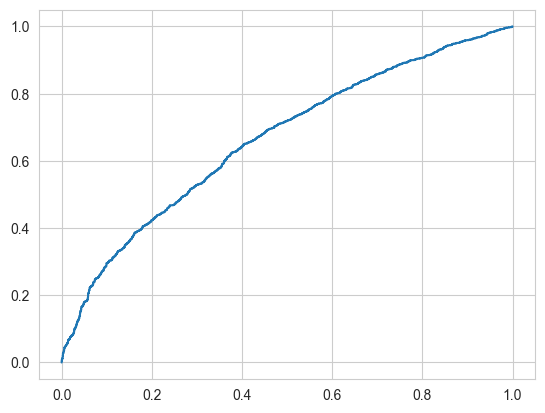

In [241]:
print(roc_auc_score(y_test, y_prob))
cur = roc_curve(y_test, y_prob)

plt.plot(cur[0], cur[1])
plt.show()

In [242]:
for i_c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]:
    clf_l_l2 = LogisticRegression(penalty='l2', C=i_c, random_state=seed, solver='liblinear').fit(X_train,
                                                                                                  np.ravel(y_train))
    print(i_c, clf_l_l2.score(X_test, y_test))

1e-05 0.6035922084492791
0.0001 0.618770554009613
0.001 0.6202883885656464
0.01 0.6182646091576018
0.1 0.618770554009613
1.0 0.6215532506956741
2 0.6213002782696686
3 0.6218062231216798
4 0.6215532506956741
5 0.6215532506956741
6 0.6218062231216798
7 0.6210473058436631
8 0.6215532506956741


In [243]:
for i_c in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]:
    clf_l_l1 = LogisticRegression(penalty='l1', C=i_c, random_state=seed, solver='liblinear').fit(X_train,
                                                                                                  np.ravel(y_train))
    print(i_c, clf_l_l1.score(X_test, y_test))
i_c = 4.5
clf_l_l1 = LogisticRegression(penalty='l1', C=i_c, random_state=seed, solver='liblinear').fit(X_train,
                                                                                              np.ravel(y_train))


1e-05 0.5350366810017708
0.0001 0.5691879585125221
0.001 0.6162408297495573
0.01 0.6180116367315962
0.1 0.6162408297495573
1.0 0.6207943334176574
2 0.6213002782696686
3 0.6215532506956741
4 0.6220591955476853
5 0.6220591955476853
6 0.6220591955476853
7 0.6218062231216798
8 0.6218062231216798


In [244]:
clf_l_l1.coef_

array([[-4.62327463e-03,  1.10483990e-02, -8.81345866e-02,
         1.96338774e-02,  2.36272858e-02, -2.23097869e-04,
        -2.52117512e-03, -9.42945780e-04,  3.01988700e-02,
         1.46400461e-01,  5.98437654e-03,  1.59528476e-01,
        -3.39367208e-01, -1.75401204e-01, -4.70842635e-01,
         1.42931330e-01,  3.74044549e-02,  1.29704866e-01,
        -1.72576332e-01,  2.51737647e-01]])

### Neural Network

In [226]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, dims, act=False):
        super(LinearClassifier, self).__init__()
        self.act = act
        self.linears = torch.nn.ModuleList()
        for idx in range(len(dims) - 1):
            self.linears.append(torch.nn.Linear(dims[idx], dims[idx + 1]))

    def forward(self, x):
        output = x
        for ly in self.linears:
            if self.act:
                output = torch.relu(output)
            output = ly(output)
        output = torch.sigmoid(output)

        return output

    def predict(self, x, thresh=0.5):
        output = x
        for ly in self.linears:
            if self.act:
                output = torch.relu(output)
            output = ly(output)
        output = torch.sigmoid(output)
        output = [xi >= thresh for xi in torch.squeeze(output)]

        return output

In [256]:
def train_nn(nn_k, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000):
    losses = []
    losses_test = []
    Iterations = []
    iter = -1
    for epoch in range(epochs):
        x = X_train_ts
        labels = y_train_ts
        optimizer.zero_grad()  # Setting our stored gradients equal to zero
        outputs = nn_k(x)
        loss = criterion(outputs, labels)

        loss.backward()  # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step()  # Updates weights and biases with the optimizer (SGD)

        iter += 1

        if iter % 20 == 0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = nn_k(X_val_ts)
                loss_test = criterion(outputs_test, y_val_ts)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_val_ts.size(0)
                correct_test += np.sum(predicted_test == y_val_ts.detach().numpy())
                accuracy_test = 100 * correct_test / total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train_ts.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train_ts.detach().numpy())
                accuracy = 100 * correct / total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

    return nn_k


def train_nn_with_l1(nn_k, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, l1=0.01, epochs=1000):
    losses = []
    losses_test = []
    Iterations = []
    iter = -1
    for epoch in range(epochs):
        x = X_train_ts
        labels = y_train_ts
        optimizer.zero_grad()  # Setting our stored gradients equal to zero
        outputs = nn_k(x)
        l1_reg = 0
        for para in nn_k.parameters():
            l1_reg += torch.sum(torch.abs(para))

        loss = criterion(outputs, labels) + l1 * l1_reg
        loss.backward()  # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step()  # Updates weights and biases with the optimizer (SGD)

        iter += 1

        if iter % 20 == 0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = nn_k(X_val_ts)

                l1_reg = 0
                for para in nn_k.parameters():
                    l1_reg += torch.sum(torch.abs(para))

                loss_test = criterion(outputs_test, y_val_ts)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_val_ts.size(0)
                correct_test += np.sum(predicted_test == y_val_ts.detach().numpy())
                accuracy_test = 100 * correct_test / total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train_ts.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train_ts.detach().numpy())
                accuracy = 100 * correct / total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test} \n l1 loss: {l1_reg}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

    return nn_k

In [228]:
X_train_np = np.array(X_train).astype(float)
y_train_np = np.array(y_train).astype(float)
X_test_np = torch.Tensor(np.array(X_test).astype(float))
y_test_np = torch.Tensor(np.array(y_test).astype(float))

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_np, y_train_np,
                                                              test_size=0.25,
                                                              random_state=seed)

X_train_ts, X_val_ts, X_test_ts = torch.Tensor(X_train_np), torch.Tensor(X_val_np), torch.Tensor(X_test_np)
y_train_ts, y_val_ts, y_test_ts = torch.Tensor(y_train_np), torch.Tensor(y_val_np), torch.Tensor(y_test_np)

In [217]:
nn_l = LinearClassifier([len(X_train_np[0]), 1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(nn_l.parameters(), lr=2e-4)

nn_l = train_nn(nn_l, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)

Iteration: 0. 
Test - Loss: 2.6070327758789062. Accuracy: 54.13609916519099
Train -  Loss: 2.925916910171509. Accuracy: 563958.0971659919

Iteration: 20. 
Test - Loss: 1.2053086757659912. Accuracy: 56.43814824184164
Train -  Loss: 1.1912716627120972. Accuracy: 595029.9595141701

Iteration: 40. 
Test - Loss: 1.1166075468063354. Accuracy: 56.99468757905388
Train -  Loss: 1.0918006896972656. Accuracy: 594374.0890688259

Iteration: 60. 
Test - Loss: 1.0502108335494995. Accuracy: 56.79230963824943
Train -  Loss: 1.0293036699295044. Accuracy: 594628.2388663967

Iteration: 80. 
Test - Loss: 0.9911094903945923. Accuracy: 57.01998482165444
Train -  Loss: 0.9737199544906616. Accuracy: 595177.5303643724

Iteration: 100. 
Test - Loss: 0.9395629167556763. Accuracy: 57.171768277257776
Train -  Loss: 0.9253186583518982. Accuracy: 595571.052631579

Iteration: 120. 
Test - Loss: 0.8955408930778503. Accuracy: 57.27295724766
Train -  Loss: 0.8840181827545166. Accuracy: 596423.6842105263

Iteration: 140. 

In [218]:
nn_l_s = LinearClassifier([len(X_train_np[0]), 1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(nn_l_s.parameters(), momentum=0.9, lr=2e-4)

nn_l_s = train_nn(nn_l_s, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)

Iteration: 0. 
Test - Loss: 3.37021541595459. Accuracy: 50.771565899316975
Train -  Loss: 4.189990520477295. Accuracy: 635300.4048582996

Iteration: 20. 
Test - Loss: 1.4316766262054443. Accuracy: 52.314697697950926
Train -  Loss: 1.551377296447754. Accuracy: 635677.5303643724

Iteration: 40. 
Test - Loss: 0.911888837814331. Accuracy: 53.73134328358209
Train -  Loss: 0.9098217487335205. Accuracy: 618985.6275303643

Iteration: 60. 
Test - Loss: 0.7461252808570862. Accuracy: 54.41436883379711
Train -  Loss: 0.7562097907066345. Accuracy: 597981.3765182187

Iteration: 80. 
Test - Loss: 0.6974267959594727. Accuracy: 55.55274475082216
Train -  Loss: 0.6968273520469666. Accuracy: 606729.048582996

Iteration: 100. 
Test - Loss: 0.6927720308303833. Accuracy: 56.64052618264609
Train -  Loss: 0.689319908618927. Accuracy: 602679.048582996

Iteration: 120. 
Test - Loss: 0.6877872943878174. Accuracy: 56.99468757905388
Train -  Loss: 0.6844087839126587. Accuracy: 602851.2145748988

Iteration: 140. 
T

In [229]:
nn_l_adam = LinearClassifier([len(X_train_np[0]), 1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_l_adam.parameters(), lr=0.001)

nn_l_adam = train_nn(nn_l_adam, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)

Iteration: 0. 
Test - Loss: 18.18303680419922. Accuracy: 53.5542625853782
Train -  Loss: 18.205808639526367. Accuracy: 640727.7327935223

Iteration: 20. 
Test - Loss: 15.577570915222168. Accuracy: 53.2001011889704
Train -  Loss: 15.548083305358887. Accuracy: 639989.8785425101

Iteration: 40. 
Test - Loss: 12.787200927734375. Accuracy: 52.82064254996205
Train -  Loss: 12.617386817932129. Accuracy: 638653.5425101215

Iteration: 60. 
Test - Loss: 9.583593368530273. Accuracy: 51.8593473311409
Train -  Loss: 9.513964653015137. Accuracy: 636103.8461538461

Iteration: 80. 
Test - Loss: 7.467722415924072. Accuracy: 50.31621553250696
Train -  Loss: 7.15646505355835. Accuracy: 629463.1578947369

Iteration: 100. 
Test - Loss: 6.604668617248535. Accuracy: 48.570705793068555
Train -  Loss: 6.024292945861816. Accuracy: 611254.5546558704

Iteration: 120. 
Test - Loss: 6.225675582885742. Accuracy: 47.12876296483683
Train -  Loss: 5.612283706665039. Accuracy: 596440.08097166

Iteration: 140. 
Test - Lo

In [246]:
nn_l_multi = LinearClassifier([len(X_train_np[0]), 30, 1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_l_multi.parameters(), lr=0.001)

nn_l_multi = train_nn(nn_l_multi, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)


Iteration: 0. 
Test - Loss: 10.508774757385254. Accuracy: 45.88919807740956
Train -  Loss: 13.149428367614746. Accuracy: 544568.9271255061

Iteration: 20. 
Test - Loss: 1.6060242652893066. Accuracy: 48.41892233746522
Train -  Loss: 1.7154561281204224. Accuracy: 626634.7165991903

Iteration: 40. 
Test - Loss: 1.2922370433807373. Accuracy: 47.50822160384518
Train -  Loss: 1.2886101007461548. Accuracy: 613328.7449392712

Iteration: 60. 
Test - Loss: 0.9924436807632446. Accuracy: 46.77460156842904
Train -  Loss: 0.9961879849433899. Accuracy: 609024.5951417004

Iteration: 80. 
Test - Loss: 0.7921686768531799. Accuracy: 47.280546420440174
Train -  Loss: 0.796733021736145. Accuracy: 609696.8623481782

Iteration: 100. 
Test - Loss: 0.7049551010131836. Accuracy: 53.57955982797875
Train -  Loss: 0.7025899887084961. Accuracy: 620231.7813765182

Iteration: 120. 
Test - Loss: 0.6815851926803589. Accuracy: 56.539337212243865
Train -  Loss: 0.6749976873397827. Accuracy: 616288.3603238866

Iteration: 

In [231]:
nn_l_multi_act = LinearClassifier([len(X_train_np[0]), 30, 1], act=True)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_l_multi_act.parameters(), lr=0.001)

nn_l_multi_act = train_nn(nn_l_multi_act, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=3000)


Iteration: 0. 
Test - Loss: 2.5047736167907715. Accuracy: 53.65545155578042
Train -  Loss: 2.6755449771881104. Accuracy: 641326.2145748988

Iteration: 20. 
Test - Loss: 0.9943035244941711. Accuracy: 51.90994181634202
Train -  Loss: 1.004766583442688. Accuracy: 581715.7894736842

Iteration: 40. 
Test - Loss: 0.7593207359313965. Accuracy: 52.87123703516317
Train -  Loss: 0.7501481771469116. Accuracy: 591275.1012145749

Iteration: 60. 
Test - Loss: 0.6888179183006287. Accuracy: 57.804199342271694
Train -  Loss: 0.6805933117866516. Accuracy: 599932.5910931174

Iteration: 80. 
Test - Loss: 0.6770153641700745. Accuracy: 58.84138628889451
Train -  Loss: 0.6683632135391235. Accuracy: 615345.5465587045

Iteration: 100. 
Test - Loss: 0.6696030497550964. Accuracy: 59.54970908171009
Train -  Loss: 0.6626255512237549. Accuracy: 611902.2267206478

Iteration: 120. 
Test - Loss: 0.6662985682487488. Accuracy: 59.752087022514544
Train -  Loss: 0.6587241291999817. Accuracy: 610041.1943319838

Iteration: 

In [258]:
nn_l_multi = LinearClassifier([len(X_train_np[0]), 30, 1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_l_multi.parameters(), lr=0.001)

nn_l_multi = train_nn_with_l1(nn_l_multi, criterion, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts,l1=5e-4, epochs=1000)

Iteration: 0. 
Test - Loss: 9.156573295593262. Accuracy: 46.77460156842904 
 l1 loss: 71.78056335449219
Train -  Loss: 12.741158485412598. Accuracy: 545593.7246963562

Iteration: 20. 
Test - Loss: 1.5719664096832275. Accuracy: 53.60485707057931 
 l1 loss: 71.41685485839844
Train -  Loss: 1.702867031097412. Accuracy: 641400.0

Iteration: 40. 
Test - Loss: 0.8445684313774109. Accuracy: 52.84593979256261 
 l1 loss: 70.55846405029297
Train -  Loss: 0.8358612060546875. Accuracy: 639440.5870445344

Iteration: 60. 
Test - Loss: 0.7203741669654846. Accuracy: 52.33999494055148 
 l1 loss: 69.60935974121094
Train -  Loss: 0.7552726864814758. Accuracy: 616386.7408906883

Iteration: 80. 
Test - Loss: 0.6833370327949524. Accuracy: 57.829496584872246 
 l1 loss: 68.56265258789062
Train -  Loss: 0.718681812286377. Accuracy: 608089.979757085

Iteration: 100. 
Test - Loss: 0.6736586689949036. Accuracy: 59.01846698709841 
 l1 loss: 67.43170928955078
Train -  Loss: 0.7059381604194641. Accuracy: 608918.0161

### Bayesian Neural Network Classifier

In [157]:
import math
from torch import nn
import torch.nn.functional as F

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])


class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)

    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    def sample(self):
        epsilon = self.normal.sample(self.rho.size())
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        output = (-math.log(math.sqrt(2 * math.pi))
                  - torch.log(self.sigma)
                  - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).mean()
        return output


#G = Gaussian(torch.Tensor(0), torch.Tensor(0.1))
#G.log_prob(G.sample())

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)

    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1 - self.pi) * prob2)).mean()


In [214]:

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-2e-1, 2e-1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))

        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-2e-1, 2e-1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))

        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)


class BayesianNetwork(nn.Module):
    def __init__(self, dims, crit, C=0.01, act=False):
        super().__init__()
        self.linears = torch.nn.ModuleList()
        self.C = C
        self.act = act
        self.criterion = crit
        for idx in range(len(dims) - 1):
            self.linears.append(BayesianLinear(dims[idx], dims[idx + 1]))

    def forward(self, x, sample=False):
        outputs = x
        for ly in self.linears:
            outputs = ly(outputs, sample)
            if self.act:
                outputs = F.relu(outputs)

        return torch.sigmoid(outputs)

    def log_prior(self):
        su = 0
        for ly in self.linears:
            su += ly.log_prior
        return su

    def log_variational_posterior(self):
        su = 0
        for ly in self.linears:
            su += ly.log_variational_posterior
        return su

    def sample_elbo(self, input, target, samples=1):
        outputs = torch.zeros(samples, input.size()[0], 1)
        for i in range(1):
            outputs[i] = self(input, sample=True)
        log_prior = self.log_prior()
        log_variational_posterior = self.log_variational_posterior()
        #negative_log_likelihood = F.nll_loss(outputs.reshape(-1), target.reshape(-1).type(torch.LongTensor))
        negative_log_likelihood = self.criterion(outputs.reshape(-1), target.reshape(-1))

        loss = self.C * (log_variational_posterior - log_prior) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [243]:
def train_bnn(nn_k, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000, sample=False):
    losses = []
    losses_train = []
    losses_test = []
    losses_prio = []
    losses_prob = []
    Iterations = []

    iter = -1
    for epoch in range(epochs):
        nn_k.train()
        x = X_train_ts
        labels = y_train_ts

        nn_k.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = nn_k.sample_elbo(x, labels)
        loss.backward()
        optimizer.step()
        outputs = nn_k(x.detach())
        iter += 1

        if iter % 20 == 0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                loss_test, log_prior_test, log_variational_posterior_test, negative_log_likelihood_test = nn_k.sample_elbo(
                    X_val_ts, y_val_ts)
                print("all_loss", loss_test)
                print("error", negative_log_likelihood_test)
                print("prob", log_variational_posterior_test)
                print("prior", log_prior_test)
                losses_train.append(loss_test.item())
                losses_prob.append(log_variational_posterior_test.item())
                losses_prio.append(log_prior_test.item())

                nn_k.eval()
                outputs_test = nn_k(X_val_ts.detach())
                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_val_ts.size(0)
                correct_test += np.sum(predicted_test == y_val_ts.detach().numpy())
                accuracy_test = 100 * correct_test / total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train_ts.size(0)
                outputs_re = torch.squeeze(outputs).round().detach().numpy()
                label_re = torch.squeeze(y_train_ts).detach().numpy()
                correct += np.sum(outputs_re == label_re)
                accuracy = 100 * correct / total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

    plt.plot(Iterations, losses_train, c='b')
    plt.show()
    plt.plot(Iterations, losses_prob, c='r')
    plt.plot(Iterations, losses_prio, c='green')
    plt.plot(Iterations, losses_test, c='orange')
    plt.show()
    return bnn_l

all_loss tensor(2.8518)
error tensor(2.7504)
prob tensor(6.8939)
prior tensor(-3.2405)
Iteration: 0. 
Test - Loss: 2.851757526397705. Accuracy: 58.56311662028839
Train -  Loss: 1.937717080116272. Accuracy: 55.66801619433198

all_loss tensor(2.5566)
error tensor(2.4577)
prob tensor(6.6405)
prior tensor(-3.2426)
Iteration: 20. 
Test - Loss: 2.5565617084503174. Accuracy: 56.38755375664053
Train -  Loss: 1.9800631999969482. Accuracy: 56.705465587044536

all_loss tensor(1.8104)
error tensor(1.7113)
prob tensor(6.8863)
prior tensor(-3.0239)
Iteration: 40. 
Test - Loss: 1.8104166984558105. Accuracy: 57.01998482165444
Train -  Loss: 2.0148630142211914. Accuracy: 59.07557354925776

all_loss tensor(1.2347)
error tensor(1.1349)
prob tensor(6.7347)
prior tensor(-3.2410)
Iteration: 60. 
Test - Loss: 1.2347018718719482. Accuracy: 57.88009107007336
Train -  Loss: 1.8504514694213867. Accuracy: 59.27800269905533

all_loss tensor(1.5735)
error tensor(1.4744)
prob tensor(6.7989)
prior tensor(-3.1088)
Ite

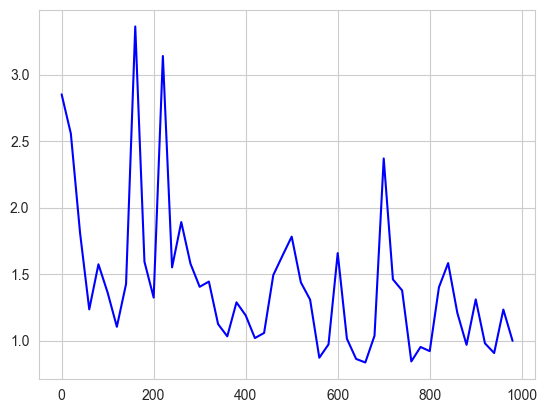

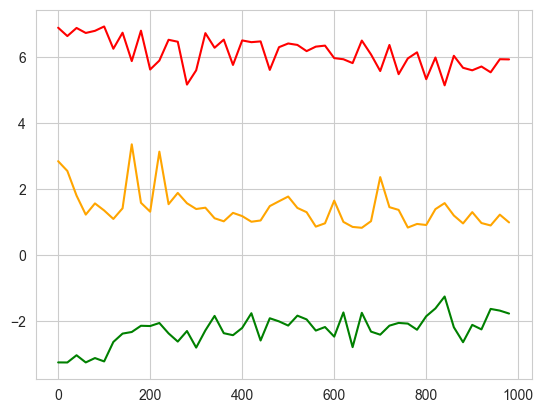

In [244]:
criterion = torch.nn.BCELoss()
bnn_l = BayesianNetwork([len(X_train_np[0]), 1], criterion, C=0.01)
optimizer = torch.optim.Adam(bnn_l.parameters())
bnn_l = train_bnn(bnn_l, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)

all_loss tensor(6.5535)
error tensor(2.0606)
prob tensor(6.1635)
prior tensor(-2.8222)
Iteration: 0. 
Test - Loss: 6.5534749031066895. Accuracy: 57.34884897546168
Train -  Loss: 6.756735801696777. Accuracy: 51.50978407557355

all_loss tensor(7.0645)
error tensor(2.5053)
prob tensor(6.6110)
prior tensor(-2.5075)
Iteration: 20. 
Test - Loss: 7.064511299133301. Accuracy: 52.26410321274981
Train -  Loss: 5.864105224609375. Accuracy: 51.20614035087719

all_loss tensor(5.7640)
error tensor(1.3274)
prob tensor(6.2054)
prior tensor(-2.6677)
Iteration: 40. 
Test - Loss: 5.7639689445495605. Accuracy: 53.65545155578042
Train -  Loss: 5.881037712097168. Accuracy: 53.02800269905533

all_loss tensor(4.9614)
error tensor(1.1893)
prob tensor(5.3136)
prior tensor(-2.2305)
Iteration: 60. 
Test - Loss: 4.961396217346191. Accuracy: 51.93523905894258
Train -  Loss: 5.776184558868408. Accuracy: 48.81072874493927

all_loss tensor(5.2192)
error tensor(0.9021)
prob tensor(5.9951)
prior tensor(-2.6393)
Iteratio

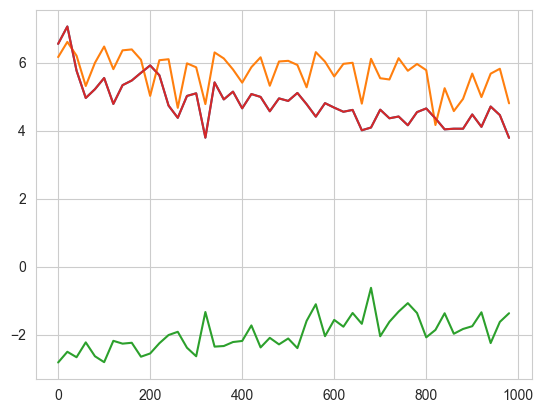

In [240]:
criterion = torch.nn.BCELoss()
bnn_l = BayesianNetwork([len(X_train_np[0]), 1], criterion, C=0.5)
optimizer = torch.optim.Adam(bnn_l.parameters())
bnn_l = train_bnn(bnn_l, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=1000)

all_loss tensor(4.8622)
error tensor(4.4758)
prob tensor(4.6127)
prior tensor(-3.1144)
Iteration: 0. 
Test - Loss: 4.8621907234191895. Accuracy: 47.83708575765242
Train -  Loss: 5.2205305099487305. Accuracy: 47.241902834008094

all_loss tensor(2.2345)
error tensor(1.9851)
prob tensor(6.1720)
prior tensor(1.1830)
Iteration: 20. 
Test - Loss: 2.2345049381256104. Accuracy: 55.07209714141159
Train -  Loss: 1.922980785369873. Accuracy: 56.80668016194332

all_loss tensor(2.0191)
error tensor(1.5801)
prob tensor(5.5519)
prior tensor(-3.2281)
Iteration: 40. 
Test - Loss: 2.019052267074585. Accuracy: 56.842904123450545
Train -  Loss: 2.266308307647705. Accuracy: 57.32118758434548

all_loss tensor(1.7581)
error tensor(1.3001)
prob tensor(6.1017)
prior tensor(-3.0570)
Iteration: 60. 
Test - Loss: 1.7580652236938477. Accuracy: 56.26106754363774
Train -  Loss: 1.5302982330322266. Accuracy: 57.9031713900135

all_loss tensor(1.9744)
error tensor(1.5410)
prob tensor(5.4404)
prior tensor(-3.2274)
Itera

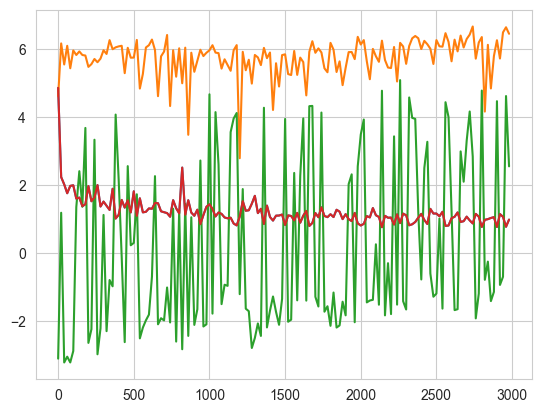

In [238]:
criterion = torch.nn.BCELoss()
bnn_l = BayesianNetwork([len(X_train_np[0]), 1], criterion, C=0.05)
optimizer = torch.optim.Adam(bnn_l.parameters(), lr=0.001)
bnn_l = train_bnn(bnn_l, optimizer, X_train_ts, y_train_ts, X_val_ts, y_val_ts, epochs=3000)